# Image Processing
Using the results of the previous notebook, we're going to try to use the OpenCV library to process the images and save them so we can then apply our motion estimation algorithms to ABI-GOES aggregate images over a certain period of time (10 days perhaps).

## Importing necessary libraries and notebooks

In [1]:
import xarray as xr
import os
import cv2
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from datetime import datetime, timedelta
from matplotlib import ticker
from IPython.display import Image, display, HTML

# Import the other notebooks without running their cells
from ii_Data_Manipulation import visualize_4
from iii_GOES_average import time_list, visualize_aggregate, calculate_median

## Preparing the Images
We're going to work on 10 images obtained from averaging all ABI-GOES images for a given day. First, we need to average the images for each day and then save them to our hard drive.

One challenge is that acquisitions don't start and end at the same time for each day (acquisitions start at 12:00 for 2022/07/24 for example), so we need to be able to collect a list of the times at which we have data. 

### Time Collector

In [3]:
def collect_times(date, directory):
    """ Collect the earliest and latest acquisition times for a given date from file names. """
    prefix = f"cls-abi-goes-global-hr_1d_{date}"
    files = [f for f in os.listdir(directory) if f.startswith(prefix)]
    times = [f.split('_')[-1].split('.')[0] for f in files]  # Assumes files are named '..._HH-MM.nc'
    if times:
        return min(times), max(times)
    return None

### Saving a Figure
Because we've encountered bugs and stack overflow when we tried to modify the function of notebook 3 by adding an optional parameter (**output_filepath**=None), which if specified saves the figure instead of showing it (and removes the legend), we've decided instead to write a new function here **save_aggregate** that can also display the image.

In [27]:
def save_aggregate(aggregate_data, lat_range=None, lon_range=None, color="viridis", vmax=0.001, threshold=0.0001, output_filepath=None, filter_clouds=True):
    # Select the desired subset
    if lat_range:
        aggregate_data = aggregate_data.sel(latitude=slice(*lat_range))
    if lon_range:
        aggregate_data = aggregate_data.sel(longitude=slice(*lon_range))

    # If filtering clouds, set NaN values to -0.1
    if filter_clouds:
        aggregate_data = xr.where(np.isnan(aggregate_data), -0.1, aggregate_data)
        
    # Set up a plot with geographic projections
    fig, ax = plt.subplots(figsize=(12, 10), subplot_kw={'projection': ccrs.PlateCarree()})
    
    # Customize the map with coastlines and features
    ax.coastlines(resolution='10m', color='black', visible=output_filepath is None)
    ax.add_feature(cfeature.BORDERS, linestyle=':', visible=output_filepath is None)
    ax.add_feature(cfeature.LAND, facecolor='lightgray', visible=output_filepath is None)


    # Show gridlines only when visualizing interactively, not when saving the output
    if output_filepath is None:
        gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--')
        gl.top_labels = False
        gl.right_labels = False
        cbar_kwargs = {'shrink': 0.35}
    else:
        cbar_kwargs = None

    # Plot the aggregate data with the specified color, vmax, and threshold (depending if output mode is on or not)
    im = aggregate_data.plot(ax=ax, x='longitude', y='latitude', transform=ccrs.PlateCarree(),
                             cmap=color, add_colorbar=output_filepath is None,
                             vmin=threshold, vmax=vmax, cbar_kwargs=cbar_kwargs if cbar_kwargs else None)
    
    # Set title and colorbar only when visualizing interactively
    if output_filepath is None:
        im.colorbar.set_label('Aggregate Floating Algae Index (FAI)')
        plot_date = aggregate_data.attrs.get('date', 'Unknown Date')
        plt.title(f"Aggregate Algae Distribution on {plot_date}")

    if output_filepath:
        plt.savefig(output_filepath)  
        plt.close(fig)  
    else:
        plt.show()  


We have the option to get the raw average (without the mask for the land) or to mask the land and we should test both images to see which is best for the OF algorithms.

### Cropping Images
Let's write a function to crop images so as to remove the white space from the figure.

In [28]:
def crop_image(image):
    # Convert to grayscale if it is a color image
    if len(image.shape) == 3:
        gray_img = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray_img = image

    # Threshold the image to isolate the content
    _, thresh = cv2.threshold(gray_img, 240, 255, cv2.THRESH_BINARY_INV)

    # Find contours from the thresholded image
    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    if contours:
        # Find the largest contour which will encompass the area of interest
        c = max(contours, key=cv2.contourArea)
        
        # Get the bounding rectangle of the largest contour
        x, y, w, h = cv2.boundingRect(c)
        
        # Crop the original image using the dimensions of the bounding rectangle
        cropped_img = image[y:y+h, x:x+w]
        return cropped_img
    else:
        print("No significant contours found.")
        return image  # Return original image if no contours were found

### Producing the Mini Database

In [29]:
def process_dates(start_date, end_date, directory, output_dir, lat_range=None, lon_range=None, color="viridis"):
    # Convert the start and end dates from strings to datetime objects
    current_date = datetime.strptime(start_date, '%Y%m%d')
    end_date = datetime.strptime(end_date, '%Y%m%d')
    
    while current_date <= end_date:
        # Format the current date as a string in 'YYYYMMDD' format
        date_str = current_date.strftime('%Y%m%d')
        
        # Discover the start and end times of image acquisition on the current day by scanning the directory
        times = collect_times(date_str, directory)
        
        if times:
            # Create a list of timestamps for the day using the discovered start and end times
            times_for_day = time_list(
                datetime.strptime(date_str + '_' + times[0], '%Y%m%d_%H-%M'),
                datetime.strptime(date_str + '_' + times[1], '%Y%m%d_%H-%M'), 
                10  # Interval between images in minutes
            )
            
            # Calculate the median distribution of algae based on the list of timestamps
            median_distribution = calculate_median(times_for_day, lat_range, lon_range)
            
            # Prepare the output file path for the current day's visualization
            output_file_path = os.path.join(output_dir, f'algae_distribution_{date_str}.png')
            
            # Visualize the median algae distribution and save it using the provided visualization function
            save_aggregate(median_distribution, lat_range, lon_range, color=color, output_filepath=output_file_path)
            # No need to save and close the plot here as it's handled within visualize_aggregate
        
        # Increment the current date by one day
        current_date += timedelta(days=1)

In [11]:
# start_date = '20220724'
# end_date = '20220802'
# directory = '/media/yahia/ballena/CLS/abi-goes-global-hr' 
# output_directory = '/home/yahia/Documents/Jupyter/Images/ABI_Averages' 
# latitude_range = (12, 17)  
# longitude_range = (-67, -60) 

# # Call the function
# process_dates(start_date, end_date, directory, output_directory, latitude_range, longitude_range, color="binary")

In [12]:
# #Displaying the result
# image_path = '/home/yahia/Documents/Jupyter/Images/algae_distribution_20220724.png'
# display(Image(filename=image_path, width = 500))

If we look at the images, we can see that some of them are covered by clouds which makes detecting the algae impossible. A solution we could implement is to use the OLCI images (if they're more clear) and add them to the ABI aggregates (using OpenCV's **OR** operator for example).

### Image Filters

#### Binarizing the Images
Binarizing the images (indicating the presence of algae by absolute black and the rest by white) might be beneficial for our Optical Flow algorithms.

In [13]:
def binarize_image(image, threshold):
    # Load image in grayscale
    image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    # Apply binary thresholding
    _, binary_image = cv2.threshold(image, threshold, 255, cv2.THRESH_BINARY)
    return binary_image

#### Bilateral Filter

In [14]:
def bilateral_image(image, diameter=9, sigmaColor=75, sigmaSpace=75):
    """
    Apply a bilateral filter to an image to reduce noise while keeping edges sharp.
    
    Parameters:
    - diameter (int): Diameter of each pixel neighborhood that is used during filtering.
                      If it is non-positive, it is computed from sigmaSpace.
    - sigmaColor (float): Filter sigma in the color space. A larger value of the parameter
                          means that farther colors within the pixel neighborhood (see sigmaSpace)
                          will be mixed together, resulting in larger areas of semi-equal color.
    - sigmaSpace (float): Filter sigma in the coordinate space. A larger value of the parameter
                          means that farther pixels will influence each other as long as their
                          colors are close enough (see sigmaColor). When d>0, it specifies the
                          neighborhood size regardless of sigmaSpace. Otherwise, d is proportional
                          to sigmaSpace.

    Returns:
    - filtered_image (ndarray): The image after applying the bilateral filter.
    """
    bilateral = cv2.bilateralFilter(image, diameter, sigmaColor, sigmaSpace)
    return bilateral

In [15]:
# image_path = "/home/yahia/Documents/Jupyter/Images/ABI_Averages/algae_distribution_20220724.png"
# image = cv2.imread(image_path)
# bilateral = bilateral_image(image, diameter=7, sigmaColor=75, sigmaSpace=75)
# new_filename = "Bilateral_algae_distribution_20220724.png"
# output_path = os.path.join('/home/yahia/Documents/Jupyter/Images/ABI_Averages_Bilateral', new_filename)
# cv2.imwrite(output_path, bilateral)
# # Displaying the non-filtered image
# display(Image(filename='/home/yahia/Documents/Jupyter/Images/ABI_Averages/algae_distribution_20220724.png', width=700)) 
# # Displaying the bilateral image
# display(Image(filename='/home/yahia/Documents/Jupyter/Images/ABI_Averages_Bilateral/Bilateral_algae_distribution_20220724.png', width=700)) 

##### Bilateral then Binarization

In [16]:
# image_path = "/home/yahia/Documents/Jupyter/Images/ABI_Averages_Bilateral/Bilateral_algae_distribution_20220724.png"
# image = cv2.imread(image_path)
# binary = binarize_image(image, threshold=180)
# new_filename = "Binarized_Bilateral_algae_distribution_20220724.png"
# output_path = os.path.join('/home/yahia/Documents/Jupyter/Images/ABI_Averages_Binarized_Bilateral', new_filename)
# cv2.imwrite(output_path, binary)
# # Displaying the binarized median image 
# display(Image(filename='/home/yahia/Documents/Jupyter/Images/ABI_Averages_Binarized_Median/Binarized_Median_algae_distribution_20220724.png', width=700))  
# # Displaying the binarized bilateral image 
# display(Image(filename='/home/yahia/Documents/Jupyter/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220724.png', width=700))  

#### ~Edge Detection~

In [138]:
def edges(image_path):
    # Load image in grayscale
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    # The thresholds for hysteresis procedure are respectively the lower and upper bounds of gradient values
    edges = cv2.Canny(image, 100, 200)
    return edges

In [17]:
# image_path = "/home/yahia/Documents/Jupyter/Images/ABI_Averages_Binarized_Median/Binarized_Median_algae_distribution_20220724.png"
# edges = edges(image_path)
# new_filename = "Edges_algae_distribution_20220724.png"
# output_path = os.path.join('/home/yahia/Documents/Jupyter/Images/ABI_Averages_Edges', new_filename)
# cv2.imwrite(output_path, edges)
# display(Image(filename='/home/yahia/Documents/Jupyter/Images/ABI_Averages_Edges/Edges_algae_distribution_20220724.png', width=700))  

Here we've applied the edge detection algorithm to the binarized filtered image. This algorithm clearly delimits the edges of the algae rafts which may be useful later on.

#### Conclusion
After trying out various combinations, it seems the best image we have obtained so far is by **applying a bilateral filter and then binarizing the image** (median filter is still an option, although bilateral filters are better for preserving the edges).

### Saving Images
This function takes as input images and applies a certain function (for now bilateral_function then binarize_image but we could generalize this to work with other functions) to them and then saves them in the provided directory.

In [25]:
def process_directory(source_dir, dest_dir, threshold=180, bilateral=False, binarize=False, crop=True):
    # # Ensure the destination directory exists
    # if not os.path.exists(dest_dir):
    #     os.makedirs(dest_dir)

    # Iterate over all files in the source directory
    for filename in os.listdir(source_dir):
        if filename.endswith('.png'):
            # Original image path
            image_path = os.path.join(source_dir, filename)
            image = cv2.imread(image_path)
            
            # Filter the image
            if bilateral:
                image = bilateral_image(image)
            
            # Binarize the image
            if binarize:
                image = binarize_image(image, threshold)

            # Crop the image
            if crop:
                image = crop_image(image)
            
            # New filename with 'Processed' prefix
            new_filename = 'Processed_' + filename
            
            # Define the output path for the processed image
            output_path = os.path.join(dest_dir, new_filename)
            
            # Save the processed image
            cv2.imwrite(output_path, image)

In [23]:
if __name__ == '__main__':
    # Paths
    source_directory = '/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages'
    destination_directory = '/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral'
    
    # Process the directory
    process_directory(source_directory, destination_directory, threshold=100, bilateral=True, binarize=True)

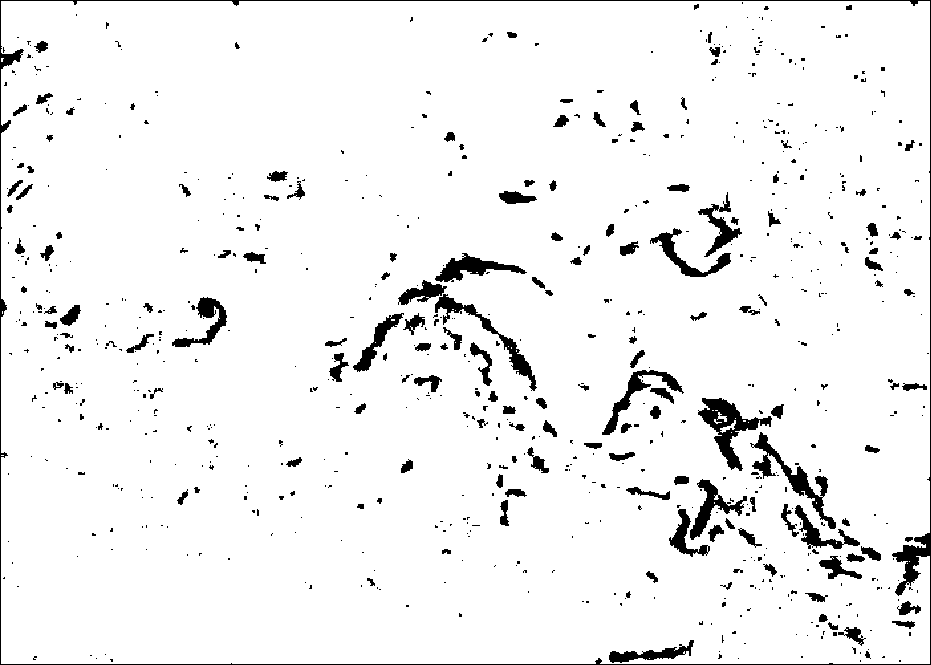

In [21]:
if __name__ == '__main__':
    # Display the processed image
    image_path = '/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Binarized_Bilateral/Binarized_Bilateral_algae_distribution_20220724.png'
    display(Image(filename=image_path, width=700))  

The **threshold** value must be chosen carefully so as to leave all the algae, but not leave the clouds, land or other undesirable features. 

This is what the Binarized version looks like (for **cmap="binary"** and **threshold=180**), this should make it easier for the OF algorithms to track the algae. If we increase the threshold (which leaves in more algae), we get a lot of discrete algae spots, which is probably not going to be good for our algorithms.

In [19]:
if __name__ == '__main__':
    image_path = '/home/yahia/Documents/Jupyter/Sargassum/Images/Binarized_algae_distribution_20220724_thresh_200.png'
    display(Image(filename=image_path, width=700))  

FileNotFoundError: [Errno 2] No such file or directory: '/home/yahia/Documents/Jupyter/Images/Binarized_algae_distribution_20220724_thresh_200.png'

This is what the binarized version looks like for **threshold=200**.
Maybe we could still use this, if we apply a filter to it (median filter for example).

## Finding a Good Example
The 10-day period we have chosen (starting on 2022/07/24 and ending on 2022/08/02) may not be enough on its own to visualize motion vectors because a lot of the acquisitions are masked by clouds, so we're going to try to find 2 consecutive days in which the detections are clear after averaging the ABI-GOES images.

After a few tries, we've found the week of 2022/07/18 - 2022/07/24 to be good, with 22, 23 and 24 having particularly clear images.

In [17]:
if __name__ == '__main__':
    start_date = '20220718'
    end_date = '20220724'
    directory = '/media/yahia/ballena/CLS/abi-goes-global-hr' 
    output_directory = '/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages' 
    latitude_range = (12, 17)  
    longitude_range = (-67, -60) 
    
    # Calculate the 1-day averages and save them
    process_dates(start_date, end_date, directory, output_directory, latitude_range, longitude_range, color="binary")
    
    # Paths
    source_directory = '/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages'
    destination_directory = '/home/yahia/Documents/Jupyter/Images/Sargassum/ABI_Averages_Binarized_Bilateral'
    
    # Process the directory (filter, binarize and crop the images)
    process_directory(source_directory, destination_directory, threshold=180, bilateral=True, binarize=True)

## Producing Viridis Images
After all the image processing we did, the algorithm may not be able to track individual pixels any more, so raw viridis images may actually be better than the images we processed.

In [30]:
if __name__ == '__main__':
    start_date = '20220718'
    end_date = '20220724'
    directory = '/media/yahia/ballena/CLS/abi-goes-global-hr' 
    output_directory = '/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Viridis' 
    latitude_range = (12, 17)  
    longitude_range = (-67, -60) 
    
    # Calculate the 1-day averages and save them
    process_dates(start_date, end_date, directory, output_directory, latitude_range, longitude_range, color="viridis")
    
    # Paths
    source_directory = '/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Viridis'
    destination_directory = '/home/yahia/Documents/Jupyter/Sargassum/Images/ABI_Averages_Processed_Viridis'
    
    # Process the directory (filter, binarize and crop the images)
    process_directory(source_directory, destination_directory, threshold=180, bilateral=False, binarize=False)